# Numerical Simulation of Differential Equations in Python
## RLC circuit

Consider the following differential equation (DE) model of a series RLC circuit,

$$ L \ddot{q} + R \dot{q} + \cfrac{1}{C}q = u $$

where $q$ denotes the charge on the capacitor,
($R$, $L$, $C$) denote the (resistor, inductor, capacitor) parameters,
and $u$ denotes a series voltage source.

Letting $x = (q,\dot{q})\in\mathbb{R}^2$ denote the state of the circuit, we can rewrite (DE) in state-space form as $\dot{x} = f(x,u)$ where,

$$\dot{x} = \frac{d}{dt}\left[\begin{array}{c} q \\ \dot{q} \end{array}\right] = \left[\begin{array}{c} \dot{q} \\ (-R\dot{q} - \cfrac{1}{C}q + u)\cfrac{1}{L} \end{array}\right] = f((q,\dot{q}),u) = f(x,u).$$

We can write in linear state space form as: 
$$ \dot{x} = 
\begin{bmatrix} \dot{q} \\ \ddot{q} \end{bmatrix} = 
\begin{bmatrix} 
0 & 1 \\ 
\cfrac{-1}{LC} & \cfrac{-R}{L} 
\end{bmatrix}
\begin{bmatrix} q \\ \dot{q} \end{bmatrix} + 
\begin{bmatrix} 0 \\ \cfrac{1}{L} \end{bmatrix}
u $$

Now, we want to simulate the response of this RLC circuit to different inputs - say, a step response or sinusoids of different frequencies. To do this, we need to write a **numerical simulation** of the system. 

## Simulation Method 1: Using Euler Integration for numerical simulation of DEs
    
If we were going to write our own numerical simulations from scratch, the method that we leverage to drive numerical integration is called [Euler's method](https://en.wikipedia.org/wiki/Euler_method). Essentially, Euler integration says: 
$$x[k+1] =  x[k]+ \cfrac{dx}{dt} \cdot dt $$

This tells us if we can determine the derivative $\cfrac{dx}{dt}$ (how the state changes), and multiply it by the time step $dt$, we are left with just $dx$ -- or how much the state should change for a given time step of length $dt$. So, we simply calculate the next state $x[k+1]$ as current state $x[k] + dx$. In a program, we would do this iteratively in a loop. For every iteration of the loop, we advance forward in time by $dt$ seconds, and then calculate the next state. We would do this over a certain number of iterations, which is determined by the length of time of the simulation and the simulation rate (i.e., time step, $dt$).  

Importantly, there are several different ways we could write down the system dyanmics: 
* linear state space: $\cfrac{dx}{dt} = Ax + Bu$
* vector of differential equations (linear or nonlinear): $\cfrac{dx}{dt} = f(x,u)$ 

But, no matter the way we choose to write down the dynamics, the general process for numerical integration is the same. Below is some example code that showcases this concept using a simulation of the RLC circuit. 


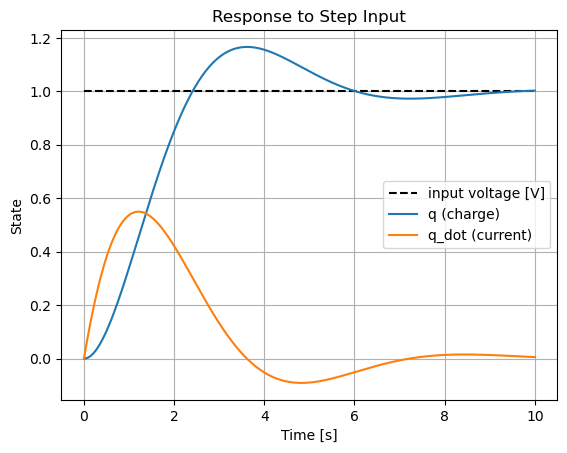

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
R = 1.0
L = 1.0 
C = 1.0

# Time parameters
dt = 0.01  # Time step
T = 10     # Total simulation time
N = int(T/dt) # Number of data points in simulation
t = np.linspace(0, T, N) # Time vector

# Define A matrix
A = np.array([[0, 1],
             [-1/(L*C), -R/L]])

# Define B matrix
B = np.array([[0],
             [1/L]])

# Input vector - can be a sinusoid, constant, whatever. In this example is it a constant = 1 (or a step response!)
u = np.array([np.ones(N)])

# Define initial conditions - for this example our state vector is x0 = (q0, q0_dot)
x0 = np.array([0,0])

# Write a function called simulate_DE that does Euler integration (x_next = x_current + dx/dt * dt). 
# Use the state-space representation to calculate dx as Ax + Bu. 
def simulate_DE(A_mat, B_mat, dt, x0, u):
    # Initialize state arrays
    x = np.array([np.zeros(N),
                   np.zeros(N)])

    # specify initial conditions
    x[:,0] = x0

    # Euler's method of integration - loop through the length of each input vector
    for i in range(1, N):
        # Define current state vector. Since we start the loop at i=1, we index using [i-1] so that our first index is q[0]. 
        x_vec = x[:,i-1]
    
        # Reference vector
        u_vec = u[:,i-1]
    
        # Compute derivative of state vector (dx) - the dynamics! Use @ for matrix multiplication
        # For this example, dx_dt = (q_dot, q_ddot)
        dx_dt = A_mat @ x_vec + B_mat @ u_vec

        # ALTERNATIVE: You could also just directly write down the dynamics from the DE in vector form. 
        # You know expressions for q_dot and q_ddot, just put them in a vector.
        dx_dt_DE = np.array([x[1,i-1], 
                              (-R*x[1,i-1] - x[0,i-1]/C + u[0,i-1])/L])

        ## ALTERNATIVE: What if we had nonlinear dynamics? (Pseudocode! won't work if you try to run)
        # dx_dt_NL = np.array(['nonlinear expression for q_dot as a function of q[i-1] and q_dot[i-1]', 
        #                        'nonlinear expression for q_ddot as a function of q[i-1] and q_dot[i-1]'])

        # Update state using Euler's method - the next state equals the current state x + dx
        x_next = x_vec + dx_dt * dt
    
        # Store the results
        x[:,i] = x_next
        # q_dot[i] = x_next[1]
    
    return x # we return vectors that have been populated with our dynamical simulation

x = simulate_DE(A,B,dt,x0,u)

q = x[0]
q_dot = x[1]
v = u[0]

# Plot the results
plt.figure()
plt.plot(t, v,'k--',label='input voltage [V]')
plt.plot(t, q, label='q (charge)')
plt.plot(t, q_dot, label='q_dot (current)')
plt.xlabel('Time [s]')
plt.ylabel('State')
plt.title('Response to Step Input')
plt.legend()
plt.grid()
plt.show()

## Simulation Method 2: Using Prof. Burden's `numerical_simulation()` function

Under the hood, this function actually does the same numerical integration we saw in Method 1. This function takes in the current state, calculates the derivative of that state based on the dynamics we define, and then integrates to find the next state. It just is optimized to be a bit more modular and flexible -- which can be powerful, but more difficult to read. If you were to want to repurpose this function for your work, you first would run this code block to define the function `numerical_simulation()` and import libraries.  

In [38]:
# First, import numerical_simulation function from class
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt

# build ODE solver
def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u)

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]

  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

Next, you would write code that calls `numerical_simulation()` to accomplish what you want. This code defines a separate function `f(t,x,u)` which is where you would write down the system-specific dynamics. This function `f(t,x,u)` is then fed into the `numerical_simulation()` function for simulation. This example code also makes use of the `lambda` function to define the input, which is just another tool to have in your toolbox for programming. 

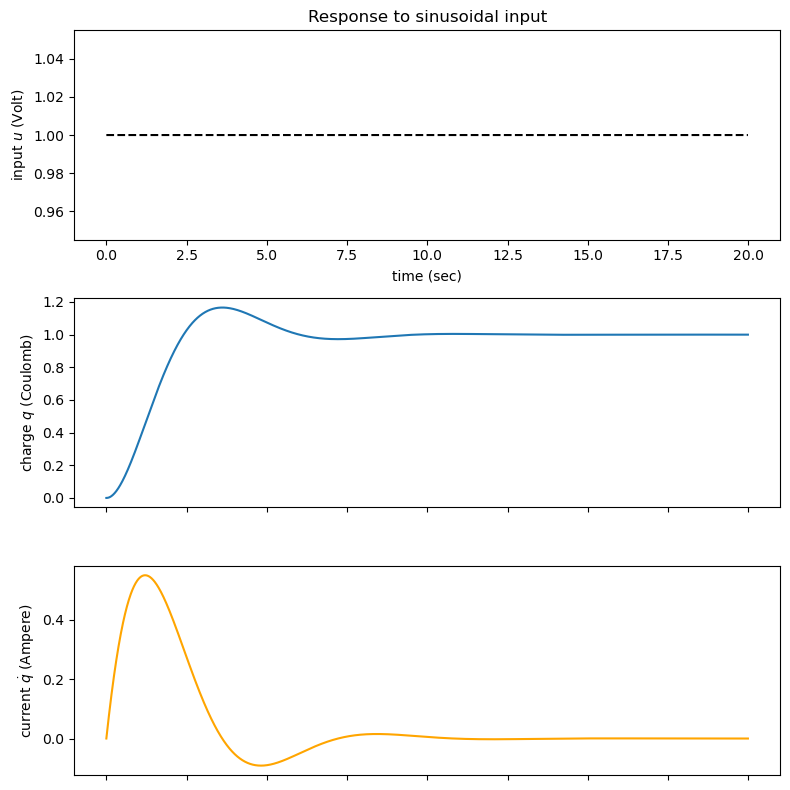

In [40]:
R,L,C = 1.,1.,1. # Ohm, Henry, Farad

dt = 1e-2 # coarse timestep
freq = .5 # one cycle every two seconds
t = 10/freq # ten periods
x0 = np.hstack((0.,0.)) # initial state (no initial charge or current)

# This is where your system-specific dynamics live
def f(t,x,u):
    q,dq = x[0],x[1] # state vector x = (x[0], x[1]) = (q, q_dot)
    return np.hstack([dq,(-R*dq - q/C + u)/L]) # this is where we declare how state x changes in time. this is dx = (q_dot, q_ddot)

# This is where you define your input - here it is done as a sinusoid, but you could make it a constant different fcn whatever
# ut = lambda t : np.sin(2*np.pi*t*freq)
ut = lambda t : 1
# lambda is a shorthand way to define a function

# -- equivalently, you could define a function for ut:
# def ut(t):
#     return np.sin(2*np.pi*t*freq)

# Simulate system using numerical_simulation() function that integrates the DE over time according to the function f (above)
t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=ut) 
u_ = np.array([ut(t) for t in t_])
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. charge and current) at time t_[j]

# Plot
fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,u_,'k--')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input $u$ (Volt)')
plt.title('Response to sinusoidal input')

ax = plt.subplot(312)
ax.plot(t_,x_[:,0],'-')
ax.set_xticklabels([])
ax.set_ylabel(r'charge $q$'+' (Coulomb)')

ax = plt.subplot(313)
ax.plot(t_,x_[:,1],'-',color='orange')
ax.set_xticklabels([])
ax.set_ylabel(r'current $\dot{q}$'+' (Ampere)')



plt.tight_layout()

## Comprehension Check!
Notice that the example code for Method 1 simulates the response to a step input and Method 2 simulates the response to a sinusoid. 
* Can you edit the code in Method 1 to simulate the response to a sinusoid? Does it match the output from Method 2?
* Can you edit the code in Method 2 to simulate a step response? Does it match the output from Method 1?